## Supervised learning

## Import libraries

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


warnings.filterwarnings('ignore')

## Retrieve data

In [6]:
path_to_csv = "/Users/emilyanderson/Desktop/HR_Engagement_Sat_Sales_UpdatedV4.0.csv"
data = pd.read_csv(path_to_csv)

In [7]:
pd.set_option('display.max_columns', None)
print(data.shape)
data.head()

(14999, 62)


,ID,Name,Department,GEO,Role,Rising_Star,Will_Relocate,Critical,Trending Perf,Talent_Level,Validated_Talent_Level,Percent_Remote,EMP_Sat_OnPrem_1,EMP_Sat_OnPrem_2,EMP_Sat_OnPrem_3,EMP_Sat_OnPrem_4,EMP_Sat_OnPrem_5,EMP_Sat_Remote_1,EMP_Sat_Remote_2,EMP_Sat_Remote_3,EMP_Sat_Remote_4,EMP_Sat_Remote_5,EMP_Engagement_1,EMP_Engagement_2,EMP_Engagement_3,EMP_Engagement_4,EMP_Engagement_5,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left_Company,CSR Factor,promotion_last_5years,sales,salary,Gender,LinkedIn_Hits,Emp_Work_Status2,Emp_Work_Status_3,Emp_Work_Status_4,Emp_Work_Status_5,Emp_Identity,Emp_Role,Emp_Position,Emp_Title,Women_Leave,Men_Leave,Emp_Competitive_1,Emp_Competitive_2,Emp_Competitive_3,Emp_Competitive_4,Emp_Competitive_5,Emp_Collaborative_1,Emp_Collaborative_2,Emp_Collaborative_3,Emp_Collaborative_4,Emp_Collaborative_5,Sensor_StepCount,Sensor_Heartbeat(Average/Min),Sensor_Proximity(1-highest/10-lowest)
0,1,BRADDY,Operations,US,VP,NaN,0,1.0,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,3,168,3,1,0,NaN,0,sales,low,M,5,4,3,1,1,1,1,2,1,NaN,1.0,2,4,2,2,2,2,2,2,1,5,1841,61,9
1,2,BORST,Sales,UK,Senior Director,NaN,0,NaN,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,5,159,2,0,0,NaN,0,accounting,low,F,58,3,3,4,3,2,1,2,1,0.0,NaN,2,2,1,4,1,3,2,5,1,5,1990,90,8
2,3,BIRDWELL,Finance,France,Senior Director,NaN,0,NaN,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,2,282,3,0,0,NaN,0,product_mng,medium,F,42,2,4,1,3,1,1,2,2,1.0,NaN,1,5,1,2,5,2,2,4,4,4,3193,80,8
3,4,BENT,Human Resources,China,Senior Director,NaN,0,NaN,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,4,278,4,1,0,NaN,0,product_mng,high,M,37,3,1,4,5,2,1,2,1,NaN,1.0,1,1,2,5,1,1,2,4,4,1,3248,77,6
4,5,BAZAN,IT,Korea,Director,NaN,0,NaN,3,6,6,0.4,3.0,3.0,4.0,3.0,5.0,2,3,2,3,2,5,5,4,4,3,0.36,6,256,5,0,0,NaN,0,sales,low,F,6,4,5,4,5,1,1,2,1,1.0,NaN,1,4,1,5,3,5,1,2,5,4,3149,80,10


In [8]:
data.drop(columns = ['ID','Name','Rising_Star', 'Trending Perf', 'Talent_Level',
                     'Validated_Talent_Level', 'EMP_Sat_OnPrem_1', 'EMP_Sat_OnPrem_2',
                     'EMP_Sat_OnPrem_3','EMP_Sat_Remote_3', 'EMP_Sat_Remote_4','EMP_Sat_Remote_5',
                     'EMP_Engagement_2','EMP_Engagement_3','EMP_Engagement_4',
                     'EMP_Engagement_5','CSR Factor','sales'], inplace = True)

data = data.rename(columns={
    'Sensor_Heartbeat(Average/Min)': 'Sensor_Heartbeat',
    'Sensor_Proximity(1-highest/10-lowest)': 'Sensor_Proximity'
})

In [9]:
# Convert column names to lower snake case
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '_')

In [10]:
# combine all the men_leave and the women_leave column

data['leave'] = data['women_leave'].fillna(data['men_leave'])
data['leave'] = data['leave'].fillna(0)
data.drop(columns = ['women_leave', 'men_leave'], inplace = True)

## Missing data handling (approximation 1 : select full columns only)

In [11]:
# impute binary missing values for critical column

data.loc[data['critical'].isna(), 'critical'] = 0

In [12]:
# covert gender column into binary classification column

data['gender'] = data['gender'].map({'F': 1, 'M': 0})

In [13]:
# impute missing values with mode as these are ranking/ordinal columns
columns_to_impute = ['emp_sat_onprem_4', 'emp_sat_onprem_5']

imputer = SimpleImputer(strategy='most_frequent')

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

In [14]:
# target imbalancing
# the target is imbalanced, however this can be sorted using the class_weight='balanced' when using LogisticRegression

data['left_company'].value_counts(normalize = True)

left_company
0    0.761917
1    0.238083
Name: proportion, dtype: float64

## Dealing with outliers for numerical columns

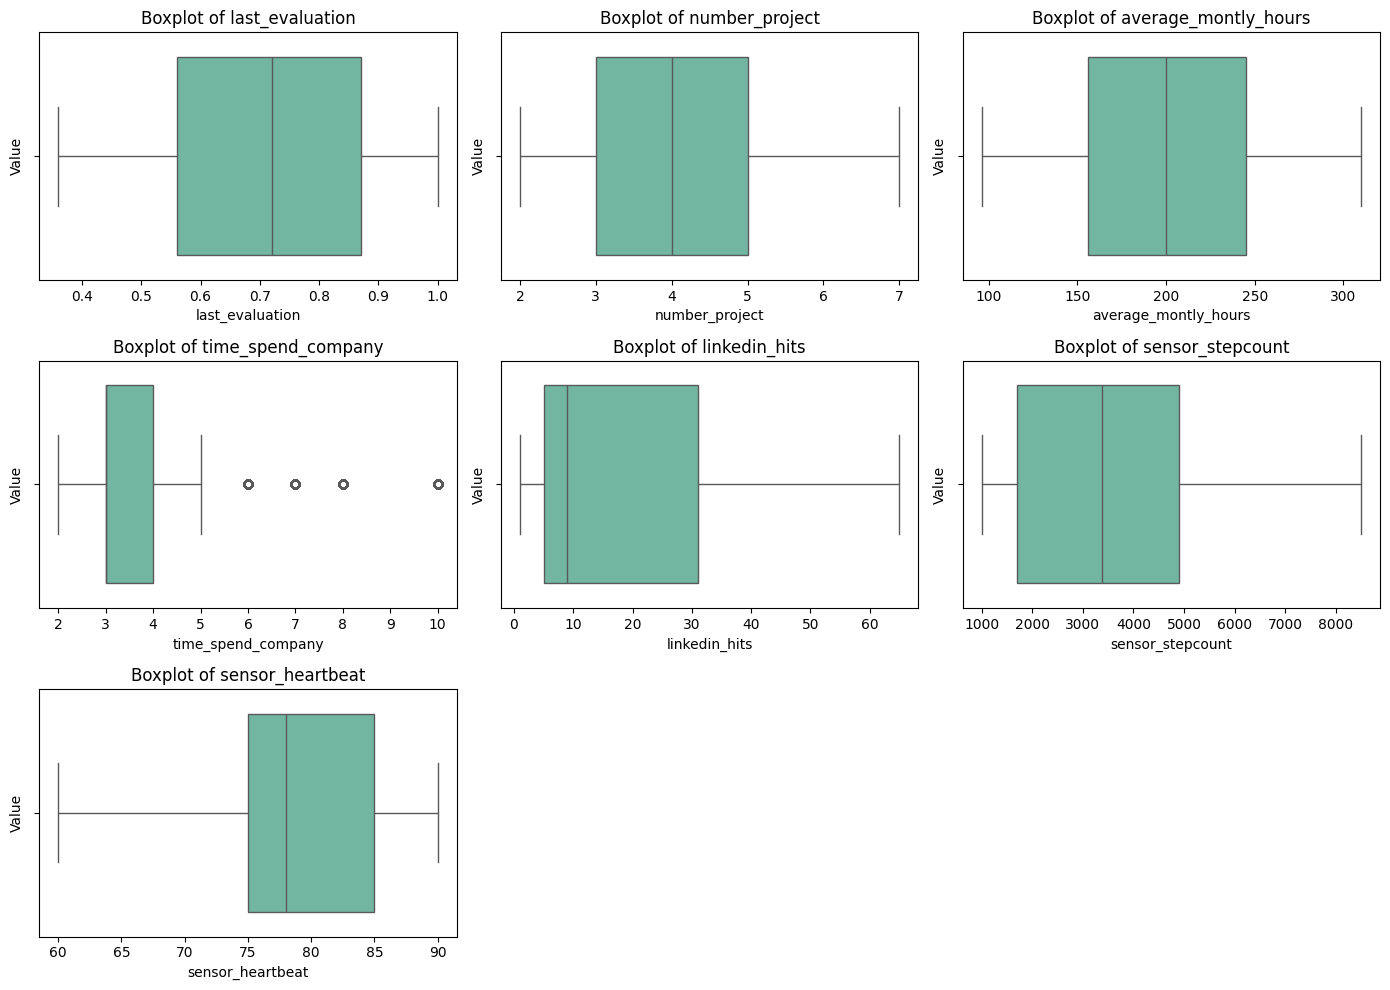

In [15]:
# detecting outliers with numerical columns only

numerical_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'time_spend_company', 'linkedin_hits', 'sensor_stepcount',
                     'sensor_heartbeat']

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=data[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [16]:
# time_spend_company is the only numeric variable with outliers therefore we will use the Robust Scaler.

rb_scaler = RobustScaler()
data['time_spend_company'] = rb_scaler.fit_transform(data[['time_spend_company']])

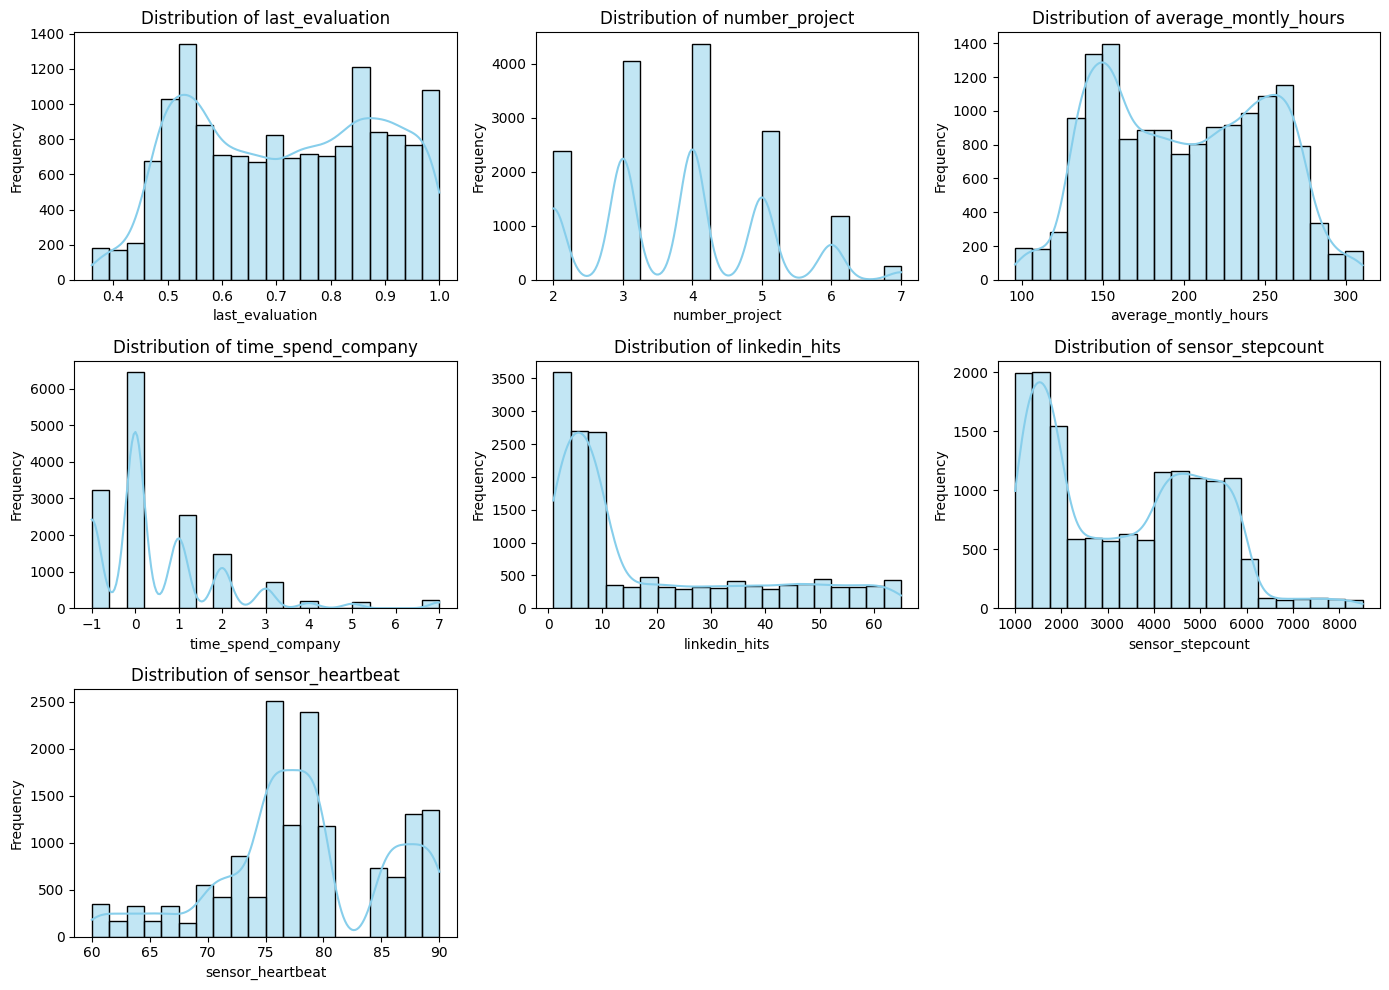

In [17]:
# plot the distributions of the numerical features to determine which scalers to use
# none of the plots seems to be normally distributed so the MinMaxScaling is chosen

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
# for all other numerical variables, use the minmaxscaler

minmaxscaler_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'linkedin_hits', 'sensor_stepcount', 'sensor_heartbeat']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
data[minmaxscaler_columns] = scaler.fit_transform(data[minmaxscaler_columns])

## Categorical Features ONLY Feature Engineering

In [19]:
# ordinal encoding for salary

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(data[['salary']])
data['encoded_salary'] = ordinal_encoder.transform(data[['salary']]) # 1 = low, 2 = medium, 3 = high
data.drop(columns = ['salary'], inplace = True)

In [20]:
# OneHotEncoding for department, geo and role

ohe_columns = ['department', 'geo', 'role']

ohe = OneHotEncoder(sparse_output = False)

ohe_data = ohe.fit_transform(data[ohe_columns])

ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))

encoded_data = pd.concat([data, ohe_df], axis=1)

encoded_data.drop(columns = ['department', 'geo', 'role'], inplace = True)

## Defining X (features) and Y (targets)

In [21]:
# define x and y variables

X = encoded_data.drop(columns = 'left_company')
y = encoded_data['left_company']

## Feature correlation

<Axes: >

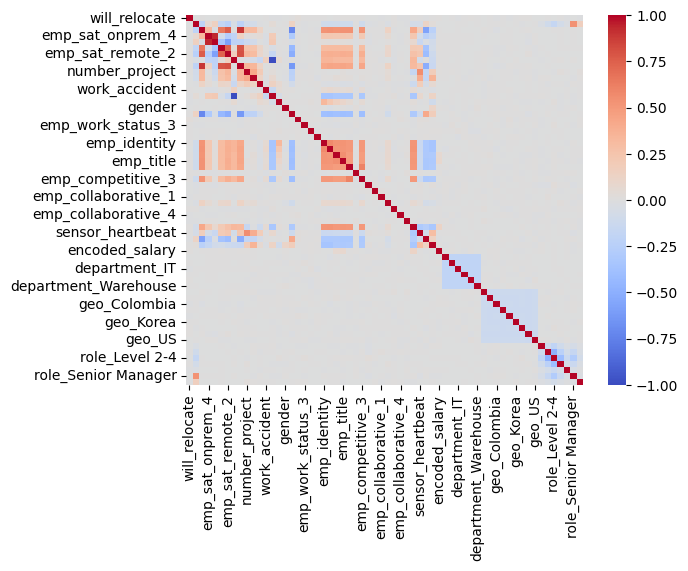

In [22]:
# Correlation Matrix
sns.heatmap(encoded_data.corr(), cmap='coolwarm')

In [23]:
# Calculate the correlation matrix
corr_matrix = X.corr()

In [24]:
# Create an empty list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, col in enumerate(corr_matrix.columns):
    for j, index in enumerate(corr_matrix.index):
        if i < j:  # Only store pairs once to avoid duplicates and self-correlation
            correlation_pairs.append([index, col, corr_matrix.iloc[j, i]])

In [25]:
# Convert the list to a DataFrame
corr_df = pd.DataFrame(correlation_pairs, columns=['feature_1', 'feature_2', 'correlation'])

# sort by correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) 
corr_df

# Remove self correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] 

# Select highly correlated features >= 0.7 or <= -0.7
correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]
correlated_features

,feature_1,feature_2,correlation
177,emp_sat_onprem_5,emp_sat_onprem_4,0.930062
124,last_evaluation,percent_remote,0.897223
346,last_evaluation,emp_sat_remote_2,0.805922
292,last_evaluation,emp_sat_remote_1,0.796292
122,emp_sat_remote_2,percent_remote,0.762327
290,emp_sat_remote_2,emp_sat_remote_1,0.735748
131,linkedin_hits,percent_remote,-0.713644


In [26]:
# remove highly correlated features >= 0.7 or <= -0.7

correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]

X.drop(columns = ['emp_sat_onprem_4', 'percent_remote', 'emp_sat_remote_2', 'emp_sat_remote_1', 'emp_engagement_1'], inplace = True)

## Random Forrest

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [29]:
# Evaluate the model
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       0.99      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2280    6]
 [  16  698]]


## Creating the pipeline and data preprocessing

In [30]:
# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


NameError: name 'preprocessor' is not defined

In [31]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluating the model

In [32]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       0.99      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2280    6]
 [  16  698]]


## Feature importance

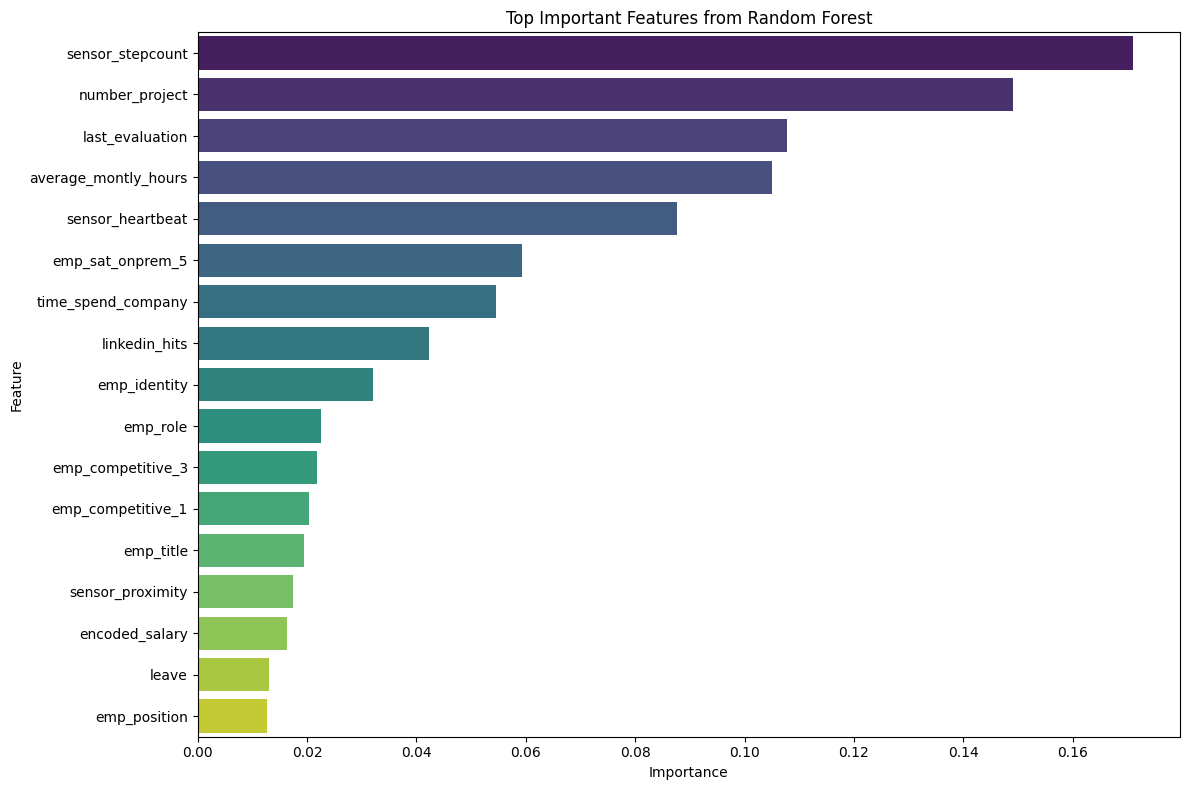

In [33]:
feature_names = X.columns.tolist()

rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
})

# Filter features with importance greater than 0.01
rf_feature_importance = rf_feature_importance[rf_feature_importance['Importance'] > 0.01]

# Plotting feature importance using Seaborn for better visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Top Important Features from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Logistic regression

In [34]:
# Create a train set and a test set, train = 10499, test = 4500
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=10)

In [35]:
# instantiate the model

log_reg = LogisticRegression(class_weight='balanced')

# fit the model to train set
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [36]:
# cross validation

cv_results = cross_validate(log_reg,
                            X_train,
                            y_train,
                            cv=5,
                            scoring=['accuracy'])

score = cv_results['test_accuracy'].mean()
print(f"Cross-validation mean accuracy results = {score}")

Cross-validation mean accuracy results = 0.8508444383947005


In [37]:
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8422222222222222
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      3449
           1       0.62      0.87      0.72      1051

    accuracy                           0.84      4500
   macro avg       0.78      0.85      0.80      4500
weighted avg       0.87      0.84      0.85      4500



## Unsupervised learning

## K-means 

In [38]:
from sklearn.cluster import KMeans

Cluster Centers:
 [[ 5.02026342e-01  5.06585613e-04  1.00000000e+00  4.63422936e-01
   3.59067882e-01  4.71846623e-01  3.37892604e-01  1.68693009e-01
   1.57041540e-02  5.09118541e-01  5.02366705e-01  2.98429585e+00
   3.04103343e+00  2.97669706e+00  2.98530902e+00  1.54660588e+00
   1.53039514e+00  1.50759878e+00  1.48885512e+00  1.56281662e+00
   3.02228977e+00  1.55521783e+00  3.05167173e+00  2.95795339e+00
   2.97669706e+00  1.54103343e+00  3.02684904e+00  3.05927052e+00
   2.98480243e+00  1.82756906e-01  6.44815941e-01  7.99645390e+00
   8.60688956e-01  1.34295846e+00  1.67173252e-01  1.66160081e-01
   1.66160081e-01  1.66666667e-01  1.65653495e-01  1.68186424e-01
   1.02836879e-01  1.10435664e-01  1.14994934e-01  1.10942249e-01
   1.05876393e-01  1.16008105e-01  1.09929078e-01  1.30699088e-01
   9.82776089e-02  4.55927052e-02  2.24417427e-01  4.59979737e-01
   1.55521783e-01  2.27963526e-02  8.40932118e-02  7.59878419e-03]
 [ 5.03631961e-01 -9.02056208e-17  4.00000000e+00  7.7574

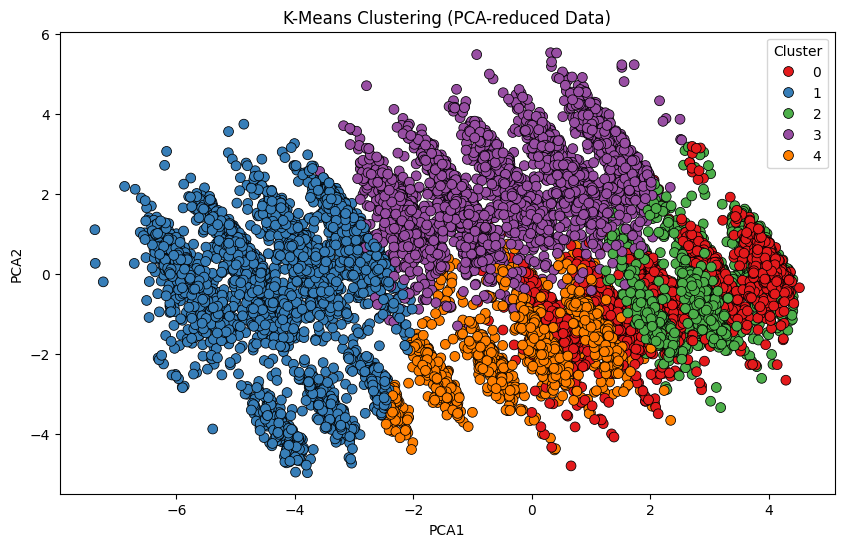

In [39]:
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

# Print cluster centers
print("Cluster Centers:\n", kmeans.cluster_centers_)

# Add the cluster labels to the original data
data['Cluster'] = kmeans.labels_

# Visualize the clusters
# For visualization purposes, we'll use the first two principal components (or any two features)
# If you have more than two features, consider using PCA to reduce dimensionality for visualization

from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = data['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

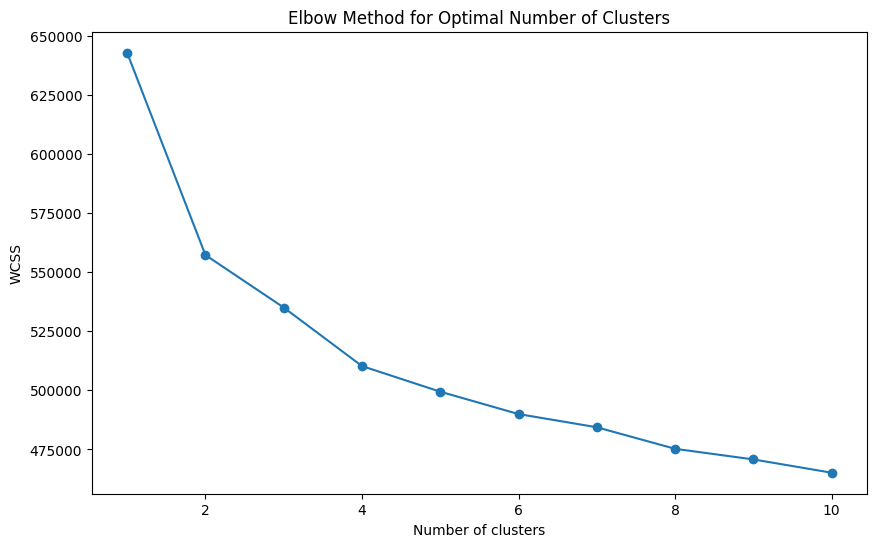

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to determine the optimal number of clusters
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [41]:
# Print cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print("Cluster Centers:\n", cluster_centers)

Cluster Centers:
    will_relocate      critical  emp_sat_onprem_5  last_evaluation  \
0       0.501056  5.279831e-04          1.000000         0.464114   
1       0.493953 -6.938894e-17          4.000000         0.837922   
2       0.531191  2.646503e-02          3.790170         0.577475   
3       0.496885 -7.632783e-17          4.000000         0.763994   
4       0.482051  6.410256e-02          4.837821         0.342829   
5       0.521969  1.058761e-03          4.001588         0.756626   
6       0.505858  7.236389e-02          4.825637         0.349802   
7       0.510549  7.876231e-02          4.824191         0.350090   
8       0.480625  9.721278e-02          4.849082         0.338237   
9       0.490460  1.683502e-03          4.014590         0.741767   

   number_project  average_montly_hours  time_spend_company  work_accident  \
0        0.358078              0.472639            0.108237       0.165787   
1        0.640930              0.737279            1.625116       

In [42]:
# Analyze the number of points in each cluster
cluster_distribution = data['Cluster'].value_counts().sort_index()
print("Cluster Distribution:\n", cluster_distribution)

Cluster Distribution:
 Cluster
0    1974
1    3304
2    3421
3    3301
4    2999
Name: count, dtype: int64


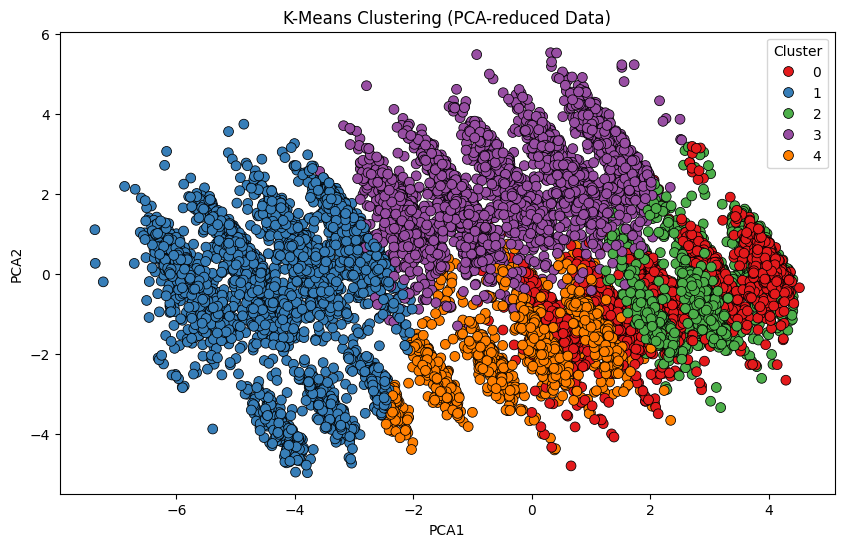

In [43]:
# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = data['Cluster']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

Comparison Table:
 Cluster              0         1         2         3         4
left_company                                                  
0             0.168533  0.239412  0.181047  0.286052  0.124956
1             0.013442  0.159059  0.378605  0.008961  0.439933


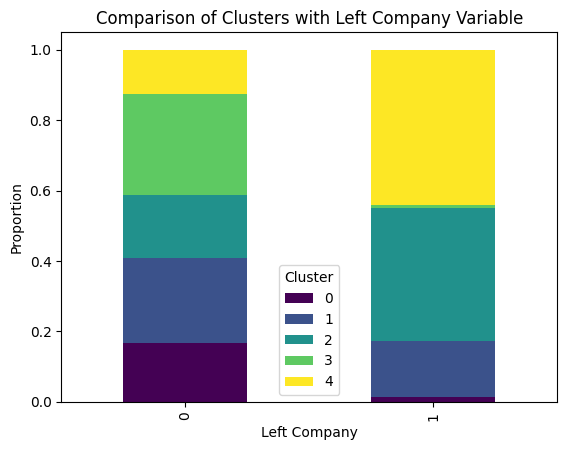

In [44]:
# If you have external variables, compare them with clusters
# For example, comparing clusters with the original 'left_company' variable

comparison_df = data[['left_company', 'Cluster']]
comparison_table = pd.crosstab(comparison_df['left_company'], comparison_df['Cluster'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Left Company')
plt.ylabel('Proportion')
plt.legend(title='Cluster')
plt.show()